In [ ]:
!pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0 opencv-python matplotlib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Setup folders
POS_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/Face ID/data','positive')
NEG_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/Face ID/data','negative')
ANC_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/Face ID/data','anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3f3e47d9-d9ee-11ec-b7c6-fc34974c1c8b.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

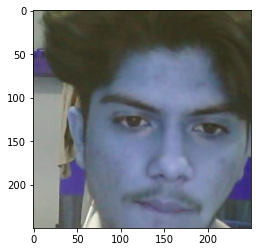

In [ ]:
plt.imshow(frame[0:0+250,0:0+250, :])

In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [7]:
import uuid

In [9]:
img_path = os.path.join(ANC_PATH, '06ba5ecf-d843-11ec-b001-90324b084670.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [10]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [8]:

anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'/content/drive/MyDrive/Colab Notebooks/Face ID/data/anchor/0f38de0b-d843-11ec-b0c3-90324b084670 (1).jpg'


In [17]:
len(negative)

3000

In [9]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
samples = data.as_numpy_iterator()
example = samples.next()

In [21]:
example

(b'/content/drive/MyDrive/Colab Notebooks/Face ID/data/anchor/1126fbbf-d843-11ec-a856-90324b084670.jpg',
 b'/content/drive/MyDrive/Colab Notebooks/Face ID/data/positive/0f35f938-e00b-11ec-8e92-0242ac1c0002.jpg',
 1.0)

In [11]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*example)

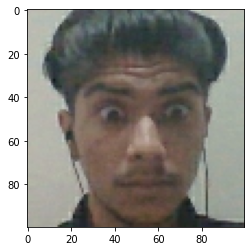

In [31]:
plt.imshow(res[1])
# res[1]

In [12]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [13]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [14]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [15]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [16]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [17]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [18]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [19]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [20]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [21]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [22]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Face ID/training_checkpoints_final'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [23]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [28]:
siamese_model.compile(loss=binary_cross_loss,optimizer=opt)

In [24]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [25]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
#         # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # train_step(batch)
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [31]:
EPOCHS = 50

In [32]:
train(train_data, EPOCHS)


 Epoch 1/50
43/43 [==============================] - 14s 324ms/step
0.0008810696 0.9969789 0.9969789

 Epoch 2/50
43/43 [==============================] - 14s 320ms/step
3.0378991e-05 1.0 1.0

 Epoch 3/50
43/43 [==============================] - 12s 282ms/step
0.00010024857 1.0 1.0

 Epoch 4/50
43/43 [==============================] - 12s 282ms/step
0.0022828258 1.0 1.0

 Epoch 5/50
43/43 [==============================] - 12s 286ms/step
0.038610086 1.0 0.99706745

 Epoch 6/50
43/43 [==============================] - 12s 286ms/step
0.13967656 0.99698794 1.0

 Epoch 7/50
43/43 [==============================] - 12s 285ms/step
0.05181456 0.9940299 0.997006

 Epoch 8/50
43/43 [==============================] - 12s 282ms/step
0.00023160908 1.0 1.0

 Epoch 9/50
43/43 [==============================] - 12s 285ms/step
1.1364725e-05 1.0 1.0

 Epoch 10/50
43/43 [==============================] - 12s 284ms/step
0.021761106 1.0 0.996875

 Epoch 11/50
43/43 [==============================] - 13s 

In [ ]:
# Import metric calculations
# from tensorflow.keras.metrics import Precision, Recall

In [46]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [47]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.0000000e+00],
       [1.0000000e+00],
       [2.9910231e-11],
       [9.9999940e-01],
       [2.5725247e-10],
       [1.0000000e+00],
       [1.7190069e-10],
       [1.0621871e-10],
       [3.1946537e-10],
       [2.2556478e-10],
       [4.8292169e-11],
       [9.9999988e-01],
       [1.0000000e+00],
       [1.0040117e-11],
       [1.0000000e+00],
       [7.6845946e-10]], dtype=float32)

In [48]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]

In [49]:
y_true

array([1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [37]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [38]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [39]:

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [57]:
# Save weights
siamese_model.save('/content/drive/MyDrive/Colab Notebooks/Face ID/siamesemodel.h5')

In [62]:
# Reload model 
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Face ID/siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist})

In [63]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[1.0000000e+00],
       [1.0000000e+00],
       [2.9910231e-11],
       [9.9999940e-01],
       [2.5725247e-10],
       [1.0000000e+00],
       [1.7190069e-10],
       [1.0621871e-10],
       [3.1946537e-10],
       [2.2556478e-10],
       [4.8292169e-11],
       [9.9999988e-01],
       [1.0000000e+00],
       [1.0040117e-11],
       [1.0000000e+00],
       [7.6845946e-10]], dtype=float32)

In [64]:
# View model summary
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [55]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/application_data', 'verification_images')):
        input_img = preprocess(os.path.join('/content/drive/MyDrive/Colab Notebooks/application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('/content/drive/MyDrive/Colab Notebooks/application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified